In [29]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import xml.etree.ElementTree as ET
import os
import numpy as np
import random
import copy
import pandas as pd
import itertools
import xmltodict
from tqdm import tqdm


from utils.util import load_from_xml, load_from_txt, bounding_box_visualization
from utils.metrics import generate_noisy_boxes, iou, mean_AP_Pascal_VOC, compute_confidences_ap
from utils.metrics import mean_IoU_nonrestricted_2 as mean_IoU_nonrestricted
from utils.rendering import group_by_frame




# TASK 1.1

In [30]:
gt_boxes,total = load_from_xml('../dataset/ai_challenge_s03_c010-full_annotation.xml')
df = pd.DataFrame(columns=['mean','std','delete_probability','generate_probability','mIOU','mAP'])
video_capture = cv2.VideoCapture('../dataset/AICity_data/train/S03/c010/vdo.avi')

NOISE PARAMETERS

In [31]:
mean = [-2,0,2]

for i in range(len(mean)):
    noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=mean[i],std=1)
    mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
    df.at[i,'mean'] = mean[i]
    df.at[i,'std'] = 1
    df.at[i,'delete_probability'] = 0.1
    df.at[i,'generate_probability'] = 0.1
    df.at[i,'mIOU'] = mIOU
    df.at[i,'mAP'] = mAP


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


In [32]:
std = [2,5,10,15]

for i in range(len(std)):
    noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=0,std=std[i])
    mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
    df.at[i+3,'mean'] = 0
    df.at[i+3,'std'] = std[i]
    df.at[i+3,'delete_probability'] = 0.1
    df.at[i+3,'generate_probability'] = 0.1
    df.at[i+3,'mIOU'] = mIOU
    df.at[i+3,'mAP'] = mAP

100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


In [33]:
noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.7,gen_prob=0.1,mean=0,std=1)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[7,'mean'] = 0
df.at[7,'std'] = 1
df.at[7,'delete_probability'] = 0.7
df.at[7,'generate_probability'] = 0.1
df.at[7,'mIOU'] = mIOU
df.at[7,'mAP'] = mAP

noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.7,mean=0,std=1)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[8,'mean'] = 0
df.at[8,'std'] = 1
df.at[8,'delete_probability'] = 0.1
df.at[8,'generate_probability'] = 0.7
df.at[8,'mIOU'] = mIOU
df.at[8,'mAP'] = mAP

noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=-2,std=15)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[9,'mean'] = -2
df.at[9,'std'] = 15
df.at[9,'delete_probability'] = 0.1
df.at[9,'generate_probability'] = 0.1
df.at[9,'mIOU'] = mIOU
df.at[9,'mAP'] = mAP


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


In [34]:
df

,mean,std,delete_probability,generate_probability,mIOU,mAP
0,-2,1,0.1,0.1,0.828429,0.900177
1,0,1,0.1,0.1,0.884785,0.901715
2,2,1,0.1,0.1,0.828615,0.810988
3,0,2,0.1,0.1,0.848674,0.900117
4,0,5,0.1,0.1,0.747763,0.807465
5,0,10,0.1,0.1,0.624672,0.627596
6,0,15,0.1,0.1,0.530649,0.373142
7,0,1,0.7,0.1,0.360871,0.355979
8,0,1,0.1,0.7,0.884856,0.850798
9,-2,15,0.1,0.1,0.528798,0.359982


### Bounding box visualization

In [35]:
noisy_bboxes = generate_noisy_boxes(gt_boxes,0.6,0.1,0,25)
AP = mean_AP_Pascal_VOC(gt_boxes,total,noisy_bboxes,iou_th=0.5)
mIOU, mIOU_frame = mean_IoU_nonrestricted(gt_boxes,noisy_bboxes)
noisy_bboxes = group_by_frame(noisy_bboxes)

frames_id = list(noisy_bboxes.keys())
frames_id.sort(key=lambda x: int(x.split('_')[1]))
# frames = random.sample(frames_id, 5)
frames = ['f_175', 'f_767', 'f_1011', 'f_1081', 'f_1337']
iou_scores = [np.mean(mIOU_frame[frame]) for frame in frames_id]

path = '../plots/noisy_bboxes'
for frame in frames:
    bounding_box_visualization(path,gt_boxes,noisy_bboxes,video_capture,frame,iou_scores)
    # print(f'{frame} IoU bboxes:')
    # print(mIOU_frame[frame])

In [36]:
# generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=mean[i],std=1)
def noisy_boxes_visualization(path,gt_boxes,video_capture, prob_del, prob_gen, mean, std):
    noisy_bboxes = generate_noisy_boxes(gt_boxes,prob_gen,prob_del,mean,std)
    AP = mean_AP_Pascal_VOC(gt_boxes,total,noisy_bboxes,iou_th=0.5)
    mIOU, mIOU_frame = mean_IoU_nonrestricted(gt_boxes,noisy_bboxes)
    noisy_bboxes = group_by_frame(noisy_bboxes)

    frames_id = list(noisy_bboxes.keys())
    frames_id.sort(key=lambda x: int(x.split('_')[1]))
    # frames = random.sample(frames_id, 5)
    frames = ['f_175', 'f_767', 'f_1011', 'f_1081', 'f_1337']
    iou_scores = [np.mean(mIOU_frame[frame]) for frame in frames_id]


    for frame in frames:
        bounding_box_visualization(path,gt_boxes,noisy_bboxes,video_capture,frame,iou_scores)
        # print(f'{frame} IoU bboxes:')
        # print(mIOU_frame[frame])

noisy_boxes_visualization('../plots/noisy_bboxes/mean', gt_boxes, video_capture, 0, 0, 20, 0 )
noisy_boxes_visualization('../plots/noisy_bboxes/std', gt_boxes, video_capture, 0, 0, 0, 15 )
noisy_boxes_visualization('../plots/noisy_bboxes/delete', gt_boxes, video_capture, 0.7, 0, 0, 0 )
noisy_boxes_visualization('../plots/noisy_bboxes/generate', gt_boxes, video_capture, 0, 0.7, 0, 0 )

# TASK 1.2

● Compute the mAP for the provided detections (mask_rcnn, ssd512, yolo3)

In [37]:
gt_boxes,total = load_from_xml('../dataset/ai_challenge_s03_c010-full_annotation.xml')

maskrcnn = '../dataset/AICity_data/train/S03/c010/det/det_mask_rcnn.txt'
ssd = '../dataset/AICity_data/train/S03/c010/det/det_ssd512.txt'
yolo = '../dataset/AICity_data/train/S03/c010/det/det_yolo3.txt' 

In [38]:

paths = [maskrcnn,yolo,ssd]
for path in paths:
    boxes = load_from_txt(path)
    # Sort by confidence
    boxes.sort(key=lambda x:x[-1], reverse=True)
    AP = mean_AP_Pascal_VOC(gt_boxes,total,boxes,iou_th=0.5)
    mIOU, _ = mean_IoU_nonrestricted(gt_boxes,boxes)

    print(path.split('/')[-1],':')
    print(mIOU, AP)

det_mask_rcnn.txt :
0.517491085842373 0.412565480432478
det_yolo3.txt :
0.4556856918835704 0.44171365289728176
det_ssd512.txt :
0.3844626012200798 0.36311370090182005


# TASK 2


Mean IoU Noisy: 0.5578437612318394


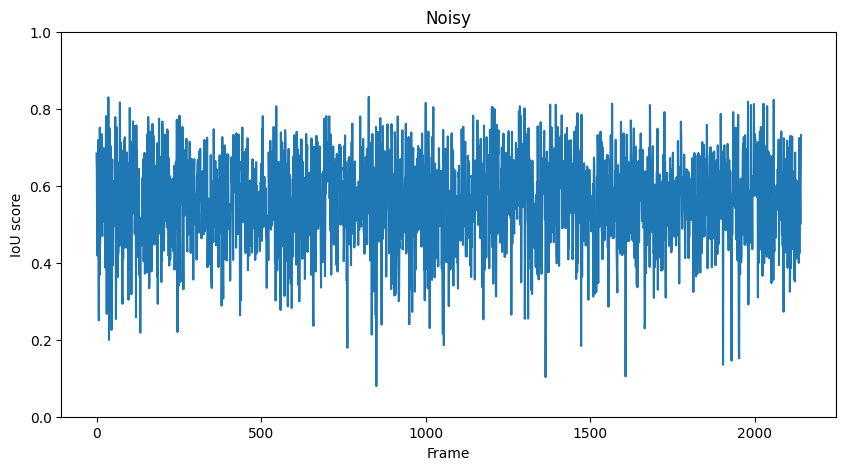

Mean IoU Mask R-CNN: 0.517491085842373


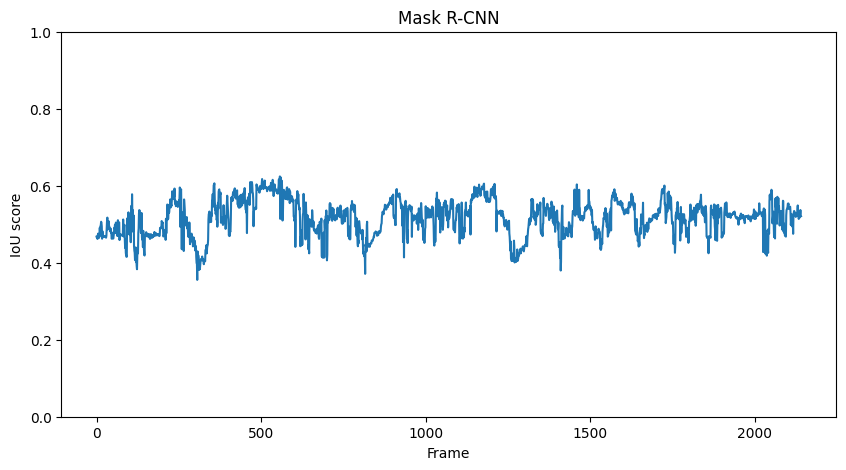

Mean IoU YOLOv3: 0.4556856918835704


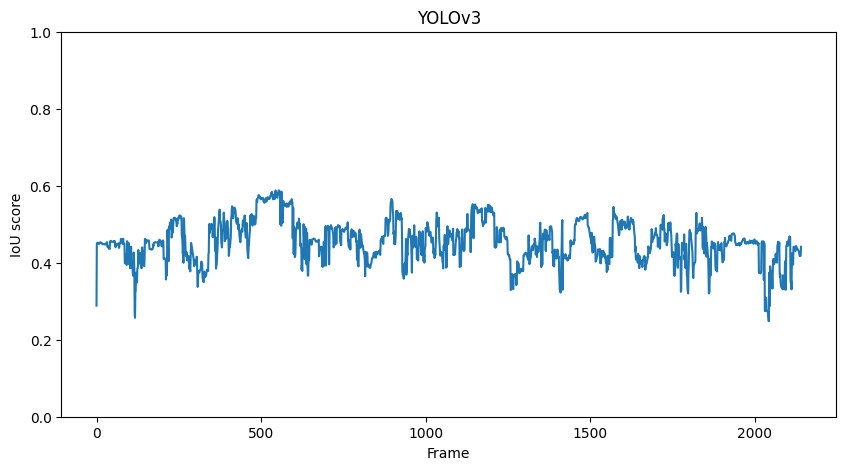

Mean IoU SSD512: 0.3844626012200798


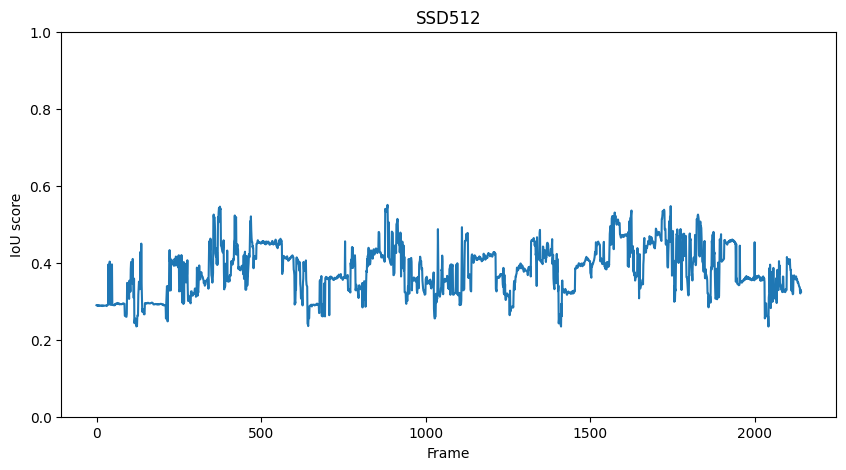

In [39]:
paths = ['noisy', maskrcnn,yolo,ssd]
name = ['Noisy', 'Mask R-CNN','YOLOv3','SSD512']
for path,name in zip(paths, name):
    if path == 'noisy':
        boxes = generate_noisy_boxes(gt_boxes,0.4,0.1,0,5)
    else:
        boxes = load_from_txt(path)
    boxes.sort(key=lambda x:x[-1], reverse=True)
    # mIOU, mIOU_frame ,AP = mean_AP_Pascal_VOC(gt_boxes,total,boxes,iou_th=0.5)
    mIOU, mIOU_frame = mean_IoU_nonrestricted(gt_boxes,boxes)

    print(f'Mean IoU {name}: {mIOU}')
    # print(f'Mean AP {name}: {AP}')

    # Plot the IoU score for each frame
    fig = plt.figure(figsize=(10,5))
    # Set title
    plt.title(name)
    frames = list(mIOU_frame.keys())
    # Sort the frames
    frames.sort(key=lambda x: int(x.split('_')[1]))
    # Convert frames to a list of integers
    frames_num = [int(frame.split('_')[1]) for frame in frames]
    iou_scores = [np.mean(mIOU_frame[frame]) for frame in frames]
    plt.plot(frames_num, iou_scores)
    plt.xlabel('Frame')
    plt.ylabel('IoU score')
    # y from 0 to 1
    plt.ylim(0,1)
    plt.show()

